## CNN

### Convolutional Layerのスクラッチ実装

In [1]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils

In [2]:
# MNISTの画像を使用
dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True)
im, label = dataset[0]
im = transforms.ToTensor()(im)[0, :, :]

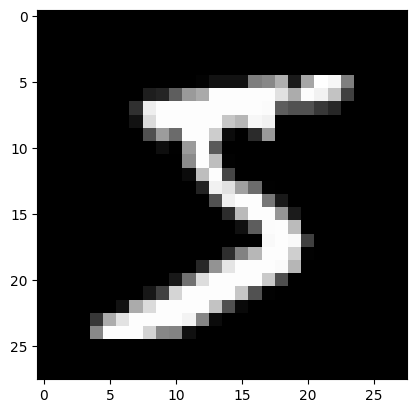

In [3]:
# MNISTの画像描画
plt.imshow(im, cmap='gray')

In [4]:
# フィルタ
top_edge_filter = torch.tensor([[-1, -1, -1],
                               [0, 0, 0],
                               [1, 1, 1]])

In [5]:
top_edge_filter

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [6]:
import pandas as pd
df = pd.DataFrame(im)
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys_r')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
def apply_filter(im, filter):
    im_h, im_w = im.shape
    f_h, f_w = filter.shape
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

In [9]:
filtered_im = apply_filter(im, top_edge_filter)
filtered_im.shape

torch.Size([26, 26])

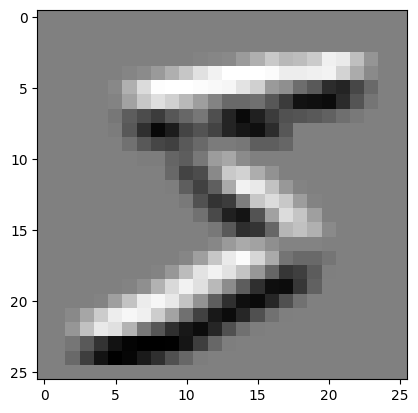

In [10]:
# 畳み込みの処理後
plt.imshow(filtered_im, cmap='gray')

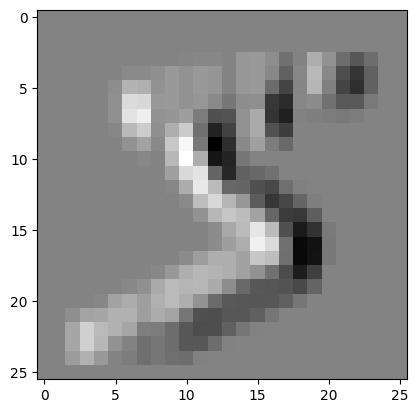

In [11]:
# left edgeフィルタでも同様に畳み込み処理を行う
left_edge_filter = torch.tensor([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])
filtered_im = apply_filter(im, left_edge_filter)
plt.imshow(filtered_im, cmap='gray')

### CNN構築

In [13]:
# Conv layer
conv_layer = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1)
list(conv_layer.parameters()) # parameter数は3x3のカーネルが4つ

[Parameter containing:
 tensor([[[[-0.1760,  0.1427, -0.2624],
           [ 0.0004, -0.0163,  0.2926],
           [ 0.0616,  0.1694, -0.0542]]],
 
 
         [[[ 0.0165,  0.2342, -0.0415],
           [-0.0755,  0.2334,  0.1766],
           [ 0.1322,  0.1831,  0.1432]]],
 
 
         [[[-0.2016,  0.0094, -0.1233],
           [ 0.2488, -0.1901, -0.1903],
           [ 0.1911, -0.2931, -0.1677]]],
 
 
         [[[-0.0827, -0.0832, -0.0493],
           [-0.0207, -0.1838,  0.1712],
           [ 0.1619, -0.3296,  0.0494]]]], requires_grad=True),
 Parameter containing:
 tensor([-0.2376,  0.1955, -0.1994, -0.3248], requires_grad=True)]

In [15]:
# CNN
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2
    
    # nn.flatten()
    # # 128
    # nn.Linear(128, 10)
    nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=1),
    # 10x1x1
    nn.Flatten()
    # 10
)

In [16]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [17]:
# モデルのパラメータ数
torch.tensor([params.numel() for params in conv_model.parameters()]).sum()

tensor(9034)

In [12]:
# サンプルのテンサーで順伝搬し，outputの形状を確認
X = torch.randn((8, 1, 28, 28))
output = conv_model(X)
output.shape

### CNN学習

In [19]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)
X_train, y_train = next(iter(train_loader))
X_train.shape

torch.Size([128, 1, 28, 28])

In [20]:
# ラベルには数字が入っている
y_train[:10]

tensor([4, 9, 8, 1, 3, 6, 2, 1, 1, 1])

In [21]:
# GPUで処理する場合は以下
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# conv_model.to(device)
opt = optim.SGD(conv_model.parameters(), lr=0.03, )
start = time.time()
# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)
end = time.time()
print(end - start)

KeyboardInterrupt: 

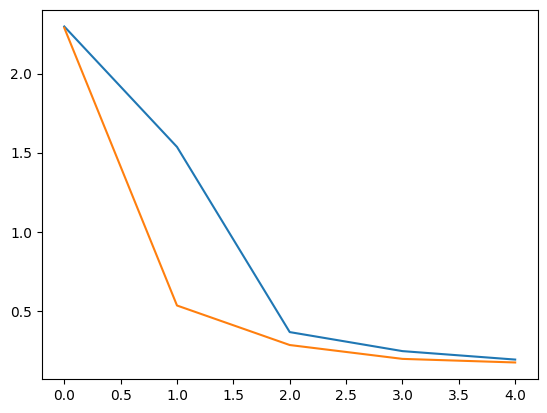

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)